In [1]:
import pandas as pd
import numpy as np
import functools as ft
import itertools as it
import multiprocessing as mp
import scipy.sparse as sp
import itertools
import matplotlib.pyplot as plt
from gensim import corpora
from collections import defaultdict
from gensim.models import TfidfModel
from collections import Counter
import json

%matplotlib notebook

In [2]:
cluster_dir = '../../results/'

louvain_clusters =pd.read_csv(cluster_dir+'louvain_clusters.txt', sep ='\t').set_index('names')
display(louvain_clusters.head(5))

louvain_small_clusters =pd.read_csv(cluster_dir+'louvain_small_clusters.txt', sep ='\t').set_index('names')
display(louvain_small_clusters.head(5))

,cluster
names,
PAK1,5
ERBB2,5
MST1R,5
YES1,5
TYRO3,5


,cluster
names,
PAK1,3
ERBB2,18
MST1R,18
YES1,18
TYRO3,18


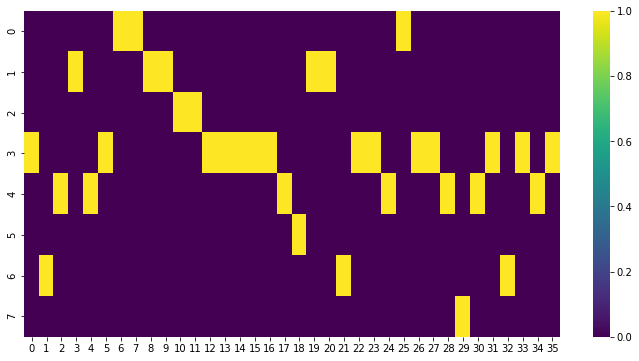

In [3]:
import seaborn as sns
from sklearn.metrics.cluster import contingency_matrix

cont_mat = pd.DataFrame(contingency_matrix(louvain_clusters, louvain_small_clusters))
#print(cont_mat.sum(axis=1))
cont_mat = cont_mat.divide(other = cont_mat.sum(axis=0),axis = 1)

fig, ax = plt.subplots(figsize=(12,6))

ann = np.copy(cont_mat)
sns.heatmap(cont_mat, ax=ax, cmap='viridis')

In [4]:
#louv_matches, spin_matches = tuple(map(list, np.where(cont_mat > 0.8)))

In [5]:
import json

In [6]:
#louv_matches = list(map(lambda x: 'supercluster_'+str(x), louv_matches))
#spin_matches = list(map(lambda x: 'subcluster_'+str(x), spin_matches))

In [7]:
parent_mapper = dict(zip(map(lambda x: 'subcluster_'+str(x), louvain_small_clusters['cluster']), map(lambda x: 'supercluster_'+str(x), louvain_clusters['cluster'])))
parent_mapper.update({x:x for x in set(map(lambda x: 'subcluster_'+str(x), list(louvain_small_clusters['cluster'].unique())))-set(parent_mapper.keys())})

In [8]:
parent_mapper

{'subcluster_3': 'supercluster_5',
 'subcluster_18': 'supercluster_5',
 'subcluster_4': 'supercluster_2',
 'subcluster_5': 'supercluster_5',
 'subcluster_6': 'supercluster_4',
 'subcluster_20': 'supercluster_2',
 'subcluster_9': 'supercluster_2',
 'subcluster_2': 'supercluster_7',
 'subcluster_12': 'supercluster_3',
 'subcluster_30': 'supercluster_8',
 'subcluster_1': 'supercluster_4',
 'subcluster_35': 'supercluster_5',
 'subcluster_10': 'supercluster_2',
 'subcluster_11': 'supercluster_3',
 'subcluster_33': 'supercluster_7',
 'subcluster_8': 'supercluster_1',
 'subcluster_24': 'supercluster_4',
 'subcluster_25': 'supercluster_5',
 'subcluster_13': 'supercluster_4',
 'subcluster_7': 'supercluster_1',
 'subcluster_26': 'supercluster_1',
 'subcluster_22': 'supercluster_7',
 'subcluster_31': 'supercluster_5',
 'subcluster_29': 'supercluster_5',
 'subcluster_27': 'supercluster_4',
 'subcluster_17': 'supercluster_4',
 'subcluster_23': 'supercluster_4',
 'subcluster_14': 'supercluster_4',
 

In [9]:
edges_df = pd.read_csv('../../data/KIN_weighted_edges.txt', sep='\t', header=None)
total_edges = pd.concat([edges_df[0], edges_df[1]])

edges_df.head()

,0,1,2
0,PAK1,ERBB2,3.0
1,MST1R,YES1,0.5
2,TYRO3,YES1,0.5
3,LYN,KIT,0.5
4,PRKCA,KIT,6.0


In [10]:
# get a list of the kinases
kin_list = list(louvain_small_clusters.index)

# define the sizes
sizes = {n:int(np.log(np.sum(total_edges==n)+.01)+1) for n in kin_list}
#sizes = {n:int(10) for n in louvain_small_clusters['names'].unique()}

# handy to have a kin_arr
kin_arr = np.array(kin_list)

In [11]:
cluster_mapper = louvain_small_clusters.to_dict()['cluster']
kin_parents = np.array([parent_mapper['subcluster_'+str(cluster_mapper[k])] for k in kin_list])
kin_children = np.array(['subcluster_'+str(cluster_mapper[k]) for k in kin_list if 'subcluster_'+str(cluster_mapper[k])])

In [12]:
parents = {par:set(kin_children[kin_parents==par].tolist()) for par in np.unique(kin_parents).tolist()}

In [13]:
# get parents plus children for parents != children
parents_plus_children = {x:{z:kin_arr[kin_children==z].tolist() for z in y if(list(y)[0] != x)} for x,y in parents.items()}

# identify parents == children
missing_parents = [x for x,y in parents_plus_children.items() if len(y)<1]
print(missing_parents)

# update to add kinases to remove parents == children
parents_plus_children = {x:y for x,y in parents_plus_children.items() if x not in missing_parents}

# place parents == children into separate dict
missing_parents = {x:kin_arr[kin_parents==x].tolist() for x in missing_parents}

# display 
parents_plus_children

[]


{'supercluster_1': {'subcluster_8': ['BMPR2',
   'BMPR1B',
   'BMPR1A',
   'ACVR2B',
   'ACVR1B',
   'ACVR1',
   'ACVR2A',
   'ACVR1C'],
  'subcluster_7': ['TGFBR2',
   'TGFBR1',
   'AMHR2',
   'ACVRL1',
   'TSSK1B',
   'DAPK2',
   'STK35',
   'CDKL1',
   'MYO3A',
   'TSSK4',
   'SGK196',
   'STK17B'],
  'subcluster_26': ['STK39', 'OXSR1', 'WNK1', 'WNK4', 'AATK', 'WNK2', 'WNK3']},
 'supercluster_2': {'subcluster_9': ['PRKCQ',
   'IKBKB',
   'CHUK',
   'MAP3K8',
   'MAP3K14',
   'RIPK1',
   'EIF2AK3',
   'MAP3K13',
   'RIPK3',
   'PRKCH',
   'TBK1',
   'IKBKE',
   'MLKL',
   'TNIK',
   'PDXK',
   'SLK',
   'CDC42BPG',
   'FLT3'],
  'subcluster_4': ['LYN',
   'SYK',
   'FLT1',
   'PRKCD',
   'BTK',
   'PIK3CG',
   'PIK3CA',
   'PRKCZ',
   'GSK3A',
   'PRKCB',
   'GSK3B',
   'PDPK1',
   'RIPK4',
   'PIK3CB',
   'AKT3',
   'PRKCI',
   'SMG1',
   'RPS6KB1',
   'ILK',
   'SGK1',
   'PDK2',
   'PDK1',
   'SGK3',
   'RPS6KB2',
   'AKT1',
   'IGF1R',
   'FLT4',
   'PIP4K2B',
   'CSF1R',
   'AKT

In [14]:
j = {"name":"viz",
     "children": [{"name": par}
                 for par in parents_plus_children.keys()]}

In [15]:
# first get the kinases of depth 3
json_out = {"name":"viz",
            "children":[
                {"name":str(parent), 
                "children":[
                    {"name":str(child), 
                    "children":[
                        {"name":str(k),
                        "size":int(sizes[k])} 
                        for k in kinases]}
                     for child, kinases in children.items()]} 
                for parent, children in parents_plus_children.items()]}

# extra json
missing_json = [
    {"name":str(parent),
    "children":[
        {"name":str(k),
        "size":int(sizes[k])}
        for k in kinases]}
    for parent, kinases in missing_parents.items()]

json_out["children"] = json_out["children"] + missing_json

In [16]:
# str_out is a JSON-formatted string from the json_out dictionary
# the 'replace' steps make the file more human-readable for debugging, etc
str_out = json.dumps(json_out).replace("},", "}, \n").replace('[{', '[\n{\n').replace(']},', ']}\n,\n')

In [17]:
with open('dist/viz.json', 'w') as f:
    f.write(str_out)